# This is your playground! Leaderboard를 정복해주세요!

## 학습 목표
- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회 2019 2nd ML month with KaKR에 직접 참여해서 문제를 해결해본다.
- 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

### 준비물
회귀 모델을 구현하는 데에 사용하는 xgboost와 lightgbm 라이브러리와, 결측 데이터를 확인하는 missingno 라이브러리를 설치한다. 

```python
$ conda install -c conda-forge xgboost
$ conda install -c conda-forge lightgbm
$ conda install -c conda-forge missingno
```
사이킷런 (scikit-learn) 버전을 0.23.0로 맞춘다.

```$ pip install scikit-learn==0.23.0```

## 대회 평가 기준 살펴보기


### Description, 대회 소개
- Competition background         
집의 가격은 누구나 알고 있지는 않죠. 집의 가격은 주거 공간의 면적, 위치, 경관, 건물의 연식 등 여러 가지 복잡한 요인의 조합에 의해 결정됩니다. 이번에 분석하실 데이터는 20개의 변수를 가지고 있으며, 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델을 만드는 것을 목표로 합니다. 이번 대회는 리더보드 점수뿐만 아니라 캐글의 공유 정신의 기본인 커널 작성을 장려하는 목표를 가지고 있습니다.

- [2019 2nd ML month with KaKR의 원 대회](https://www.kaggle.com/harlfoxem/housesalesprediction)      
원래 대회의 커널이나 토론을 참고하면 더 좋은 결과가 나올 것 같다. 

### Evaluation, 점수 평가 기준
평가 방식: Root Mean Squared Error(RMSE)

이번 대회에서 다루는 문제는 "집값"을 예측하는 문제이기 때문에 우리가 예측해야 하는 값과 실제 정답값이 모두 실숫값이다. 그 두 가지 값의 차이를 사용해 얼마나 떨어져 있는지 계산할 수 있는 RMSE를 평가 척도로 사용하는 것은 합리적이다. 

실수값을 맞추는 문제이므로 이번 대회에서 푸는 문제는 __회귀 문제__ 이다. 


## 데이터 살펴보기
### File Description, 데이터 설명
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

위의 설명에 따르면 예측해야 할 값은 가격(Price)이다. 각 변수의 값을 통해 하나의 숫자를 예측해야 하므로 __회귀 모델__ 을 사용할 것이다. 

### Data fields
- 참고: [King County Home Sales: Analysis and the limitations of a multiple regression model](https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html)

캐글 대회에 나온 설명이 잘못 되어 있는 부분이 있어서 원문과 discussion을 보면서 각 변수의 의미를 파악하였다. 

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수(0.5: 화장실, 세면대, 0.75: 화장실, 세면대, 샤워실, 1.0: 화장실, 세면대, 샤워실, 욕조)
- sqft_living : 주거 공간의 평방 피트(면적). sqft above + sqft basement
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수, 0.5는 주택의 제일 위쪽 삼각형 지붕 밑의 공간
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 전망이 얼마나 좋은지의 정도(0-4)
- condition : 집의 전반적인 상태(1-5), 1 = Poor, 2 = Fair, 3 = Average, 4 = Good, 5= Very Good
- grade : King County grading 시스템 기준(디자인 등)으로 매긴 집의 등급(1-13), 1-3은 부족함, 7은 평균, 11-13은 좋음
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 가장 가까운 15개 집의 면적의 평균
- sqft_lot15 : 가장 가까운 15개 부지의 면적의 평균

### 데이터에 대한 추가 설명
- sqft_living15와 sqft_lot15           
[데이터 필드에 대한 상세 설명](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83536)
[sqft_living15 & sqft_lot15](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/87472)
sqft_living15와 sqft_lot15의 해석이 잘못 되어 있어서 토론 게시판에 이 부분에 대한 글이 몇 개 올라왔다. 여러 글을 종합한 결과 sqft_living15와 sqft_lot15은 가까운 15개의 집과 부지의 면적의 평균인 것 같다. 

- [sqft_lot, sqft_living 등의 변수에 관해](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/87468)
> sqft_above / floors 를 하면 sqft_lot 보다 작아야 하는데, 그렇지 않은 경우가 세 case가 있어서 해당 id들은 기입에 오류가 있는 등의 문제가 있는 것 같습니다. sqft_living과 sqft_lot 등에 대해 좀 더 확인해보는 과정에서, sqft_living에 비해서 sqft_lot이 매우 (10배 이상) 데이터들이 많아서, 이상하다고 생각되어 있어서 검색을 해본 결과, 첫째로는 부동산업자들이 기록을 잘못했을 수 있다고 합니다.       
둘째로는 타운하우스나 콘도 같은 경우, 대지 전체 크기를 lot size로 표기하는 경우도 많다고 합니다. 이러한 경우 공용 대지 면적을 기입해놓은 것이니, 개별적인 집의 sqft_living 면적과는 큰 차이가 있을 수 있습니다.      
셋째로, sqft_lot 사이즈는 개별적인 집주인 전용 대지가 아닌, 다른 사람들의 이용을 허가 하는 대지 면적이 포함되는 경우도 있다고 하네요. 예를 들면 집 앞 도로와 같은 것을 포함할 수 있다고 합니다.


### Data Explorer, 데이터 파일
이번 대회에서는 데이터가 중간에 한 번 변경되었기 때문에 노드에서 알려준 url에서 파일을 다운로드 받았다. 
```python
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/kaggle-kakr-housing-data.zip
$ mv kaggle-kakr-housing-data.zip ~/aiffel/kaggle_kakr_housing
$ cd ~/aiffel/kaggle_kakr_housing
$ unzip kaggle-kakr-housing-data.zip
```

- 데이터 전처리 참고 커널            
  [House Price Prediction EDA (updated 2019.03.12)](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)
- 하이퍼파라미터 튜닝 참고    
[XGB, LGB 앙상블](https://www.kaggle.com/janged/xgb-lgb)           
[House Price Prediction](https://www.kaggle.com/poterius/house-price-prediction)
- 지도 관련 참고 커널(아직 시도하지 못했음)         
<https://www.kaggle.com/ivoryrabbit/a-note-on-using-a-single-model-xgboost>

## 라이브러리, 데이터 가져오기
### 필요한 라이브러리 import 하기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 경로 지정하기
파일의 경로를 파악하여 데이터의 경로를 지정하였다.

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/aiffel-dj44/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj44/aiffel/kaggle_kakr_housing/data/test.csv


## 데이터 탐색과 전처리
### 데이터 불러오기
데이터를 data, sub이라는 변수로 불러온다.

In [3]:
# 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('data data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

data data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
# 데이터 확인
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# 데이터 확인
sub.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


- 학습 데이터는 약 1만 5천 개, 테스트 데이터는 약 6천 개로 이루어져 있고(약 3:1의 비율) 테스트 데이터는 예측할 값인 price가 없기 때문에 컬럼이 하나 적다.
- date:년-월-일-T000000의 형태로 되어 있다. 
- price: 목적 변수이며, 데이터 셋을 수집한 시기 기준 매매가를 의미한다. (참고:<https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83957>)
- bathroom:0.5은 '화장실, 세면대', 0.75은 '화장실, 세면대, 샤워실', 1.0은 '화장실, 세면대, 샤워실, 욕조'이다. 예를 들어 1.50이라면  '화장실, 세면대, 샤워실, 욕조'로 이루어진 화장실 1개와 '화장실, 세면대'로 이루어진 화장실 1개가 존재한다는 뜻이다.
- grade: King County grading 시스템 기준(디자인 등)으로 매긴 집의 등급을 말하며, 숫자가 클수록 높은 등급이다. 
- yr_renovated: 개축한 연도가 적혀있으며, 0은 개축하지 않았음을 의미한다. 
- sqft_living15와 sqft_lot15: 가까운 이웃 15개의 집과 부지의 면적의 평균을 의미한다. 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

data 컬럼을 제외하고는 모두 숫자인 것을 알 수 있다. data 컬럼을 예측을 위한 특성으로 활용하기 위하여 날짜만 남긴 후 정수형 데이터로 만든다. 

In [7]:
# date를 날짜만 남기고, 날짜를 정수형 데이터로 처리
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
sub['date'] = sub['date'].apply(lambda i: i[:6]).astype(int)
sub.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 중복되는 데이터 확인

In [9]:
# 중복된 데이터 있는지 확인
sum(data.duplicated()), sum(sub.duplicated())

(0, 0)

중복되는 데이터는 없다.
### 결측치 확인

<AxesSubplot:>

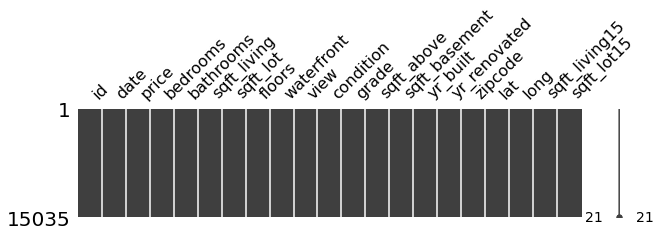

In [10]:
# missingno 라이브러리의 matrix 함수를 사용하여 데이터의 결측 상태 시각화
msno.matrix(data, figsize=(10, 2))

<AxesSubplot:>

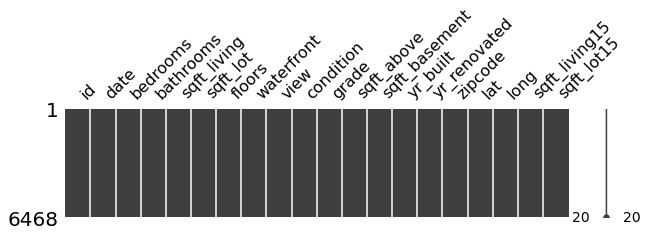

In [11]:
# missingno 라이브러리의 matrix 함수를 사용하여 데이터의 결측 상태 시각화
msno.matrix(sub, figsize=(10, 2))

In [12]:
# 결측치 개수 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [13]:
# 결측치 개수 확인
for c in sub.columns:
    print('{} : {}'.format(c, len(sub.loc[pd.isnull(sub[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


시각화와 수치를 통해서 보았을 때, 데이터에 결측치는 없다. 
### 가격과 각 변수와의 상관 관계
수치와 히트맵을 통하여 가격과 각 변수와의 상관관계를 확인해본다.

In [14]:
# id와 date를 제거
data_id = data['id']
data_date = data['date']

del data['id']
del data['date']

In [15]:
# id와 date를 제거
sub_id = sub['id']
sub_date = sub['date']

del sub['id']
del sub['date']

In [16]:
data.corr(method='pearson')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873
grade,0.667211,0.375286,0.666278,0.762543,0.119906,0.462598,0.088061,0.247924,-0.143599,1.000000,0.759240,0.162657,0.440608,0.030155,-0.186541,0.112319,0.202130,0.715321,0.119734


<AxesSubplot:>

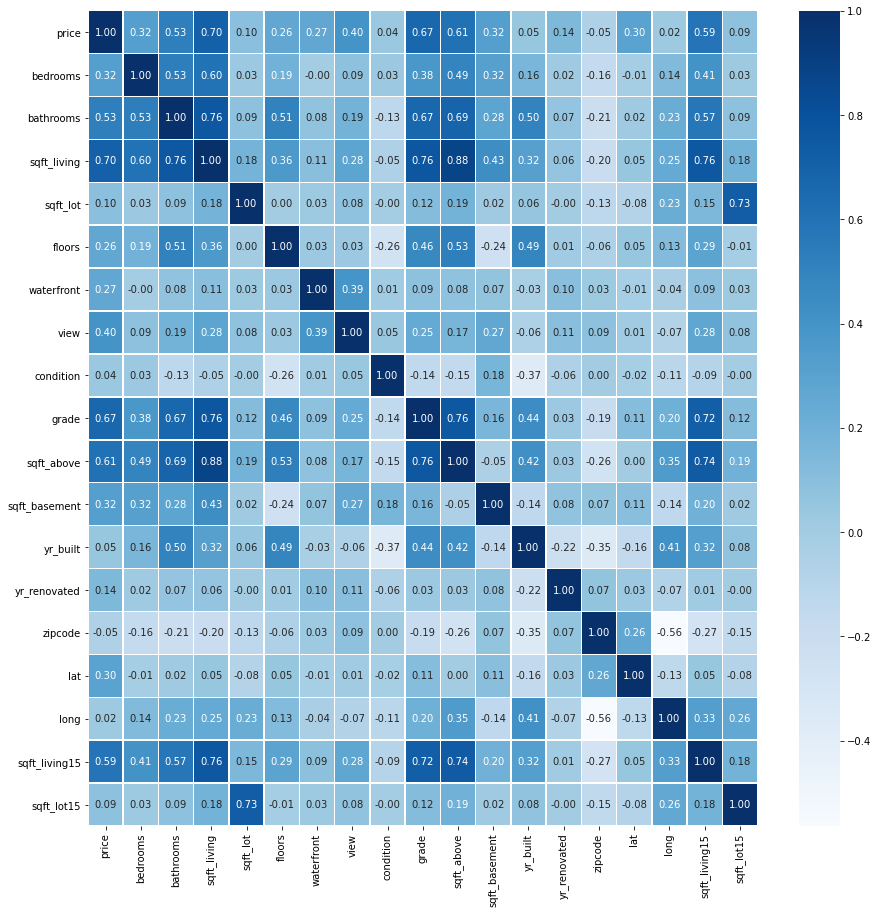

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(data = data.corr(method='pearson'), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

- 참고: [피어슨의 상관계수](https://sno-machinelearning.tistory.com/68)     

피어슨의 상관계수에 따르면 가격과 뚜렷한 양적 상관 관계를 보이는 변수는 bathrooms(0.53), sqft_living(0.70), grade(0.67), sqft_above(0.61), sqft_living15(0.59)이다. 특히 강한 양적 상관 관계를 보이는 변수는 grade이다.

In [18]:
# from lightgbm import plot_importance
# f, ax = plt.subplots(figsize=(6,6))
# plot_importance(model, max_num_features=15, ax=ax) # 상위 15개 조회

### feature importance
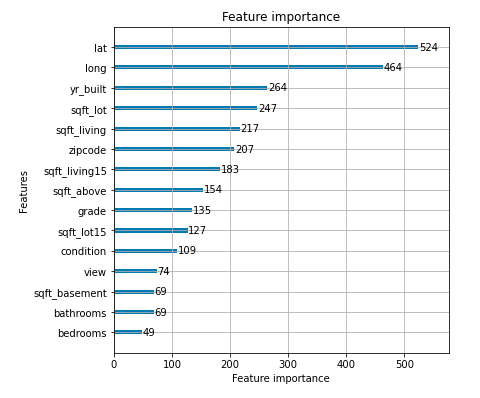
위의 그림은 lgbm 모델을 돌린 후 얻은 feature importance 그래프이다. 처음 데이터 탐색을 했을 때와는 달리 이 데이터에서 중요한 feature는 가격과 높은 상관 관계를 보인 변수들이 아니라 lat과 long, 즉 집의 위치였다. 

따라서 집의 위치에 따른 가격을 비교해보기로 했다. 참고 커널은 [Suwon study kernel](https://www.kaggle.com/wodlfrh/suwon-study-kernel)이다. 

In [19]:
data['zipcode'].unique()

array([98178, 98028, 98074, 98003, 98198, 98007, 98115, 98107, 98126,
       98019, 98103, 98002, 98133, 98040, 98030, 98119, 98112, 98027,
       98117, 98058, 98001, 98056, 98166, 98053, 98023, 98105, 98042,
       98008, 98148, 98122, 98004, 98005, 98034, 98125, 98075, 98010,
       98038, 98059, 98092, 98136, 98199, 98032, 98045, 98102, 98077,
       98108, 98168, 98177, 98118, 98006, 98146, 98033, 98052, 98155,
       98024, 98116, 98144, 98011, 98031, 98106, 98065, 98022, 98070,
       98014, 98055, 98072, 98029, 98188, 98109, 98039])

- .unstack() 
인덱스의 순위로 피봇하는 코드        
[참고](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html)        
아래의 코드는 가격에 의해서 (위도와 경도)를 순위별로 정렬한 코드 

In [20]:
a = data.groupby(['lat','long'])['price'].mean().unstack()

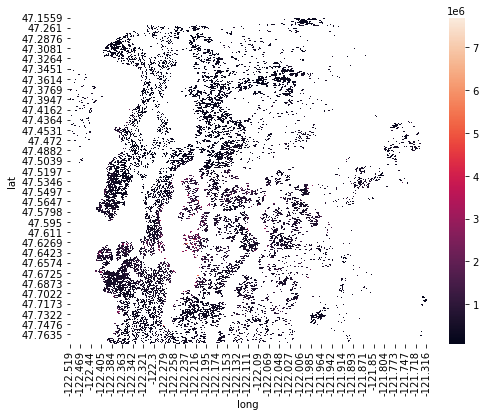

In [21]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.heatmap(a)

가격이 비싼 지역이 검게 나온다. 대체로 해변가쪽으로 갈수록 집값이 비싼 것을 알 수 있다. 

### 이상치 확인과 제거
가격과 뚜렷한 양적 상관관계를 가진 변수와 중요한 피쳐를 중심으로 이상치를 확인해 보았다. 박스플롯과 산점도를 통해 이상치 유무를 확인하고 각각의 경우를 분석하여 이상치를 제거하였다.

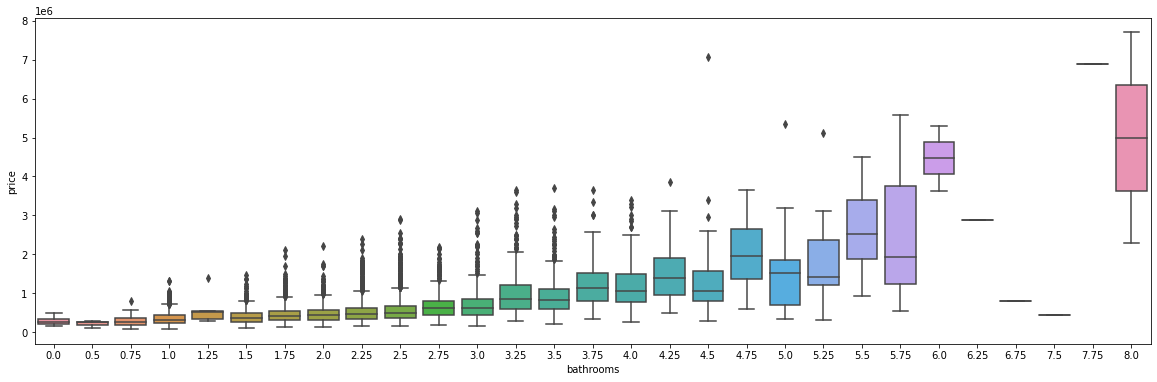

In [22]:
# bathrooms
concat_data = pd.concat([data['price'], data['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=concat_data)

In [23]:
data.loc[data['bathrooms'] >= 6.25]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2859,800000.0,7,6.75,7480,41664,2.0,0,2,3,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190
5108,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
5990,450000.0,9,7.50,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866
6469,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8912,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
10152,2888000.0,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021


화장실의 개수가 6.25, 6.75, 7.50개인 경우, 가격과 높은 상관관계를 보이는 grade가 높은데도 가격이 낮은 것이 특이하다. 화장실의 개수가 6.25, 6.75, 7.50개인 경우, 가격과 높은 상관관계를 보이는 grade가 높은데도 가격이 낮다. 그러나 그러나 이 3개의 데이터를 지우면 점수가 낮게 나오는 것으로 보아 이 데이터들은 지우면 안 될 것 같다. 이 집들의 가격은 지역에 영향을 받지 않을까 생각한다. 

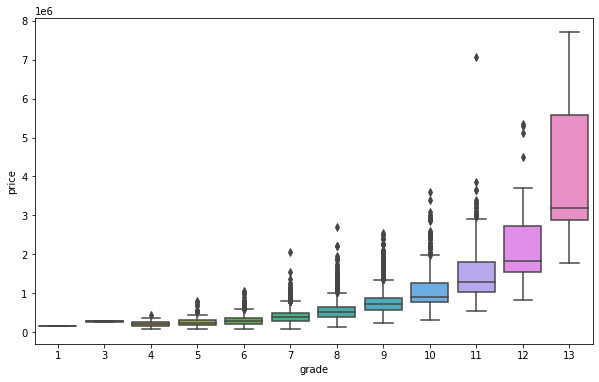

In [24]:
# grade
concat_data = pd.concat([data['price'], data['grade']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='grade', y="price", data=concat_data)

위의 박스 플롯을 보면 1) 등급 3인 집의 가격이 (조금이지만) 높고 2) 등급 7, 8, 9, 10, 11에서 이상치가 많으며 3) 등급 8, 11, 12에서 차이가 큰 이상치가 나타난다는 것을 알 수 있다. 또한 등급이 올라갈수록 가격의 분포가 넓어지는 것을 발견할 수 있다(분산이 커짐). 

In [25]:
data.loc[(data['price'] > 2500000.0)  & (data['grade'] == 8)]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,2700000.0,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


이 집의 경우 다른 집들과 조건이 별 차이가 없다. 그러나 이 데이터를 지우면 예측결과가 좋지 않아서 제거하지 않았다.

In [26]:
data.loc[(data['price'] > 7000000.0)  & (data['grade'] == 11)]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


2275의 집이 같은 grade의 집과 비교했을 때 다른 점은 개조된 시점(2001)이다. yt_renovated도 중요한 피쳐 중 하나이기 때문에 집값에 영향을 미쳤을 것이라 보고 제거하지 않았다.

In [27]:
data.loc[(data['price'] > 4000000.0)  & (data['grade'] == 12)]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
842,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
947,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1045,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
1882,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408


나머지 변수가 비슷한 조건임에도 위의 4개의 집이 높은 가격을 보이는 이유는 bathrooms의 영향인 것으로 보인다. 따라서 제거하지 않는다. 

In [28]:
data.loc[data['grade'] == 3]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,262000.0,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,280000.0,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


등급 4의 집의 가격을 보았을 때, 집의 가격이 특별히 낮은 경우(339, 10171, 11523 등)가 포함되었다는 것을 알 수 있었다. 등급 3의 경우는 집의 개수가 적기 때문에 상대적으로 등급 4보다 높게 나오는 것 같다. 또한 등급 3과 4의 가격이 큰 차이를 보이지 않으므로 제거하지 않았다. 

위의 결과로 보아 등급 7, 8, 9, 10, 11에서 이상치가 나오는 경우는 grade외의 다른 변수의 영향이 있을 것으로 예상되므로 제거하지 않았다.

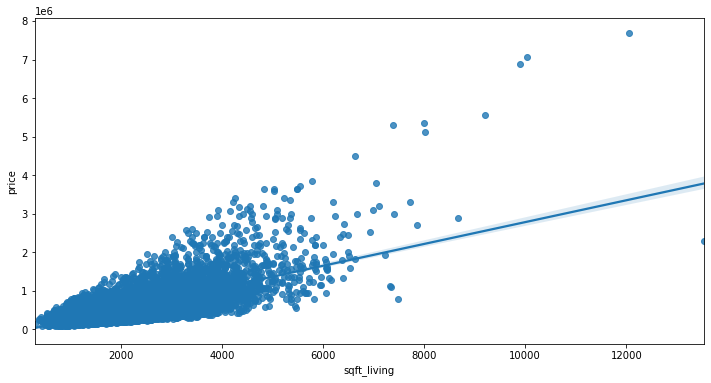

In [29]:
# sqft_living
concat_data = pd.concat([data['price'], data['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.regplot(x='sqft_living', y="price", data=concat_data)

sqft_living 컬럼의 경우, grade와 같이 등급이 나뉜 것이 아니므로 산점도를 통해 이상치를 파악하였다. 가격이 5 이상일 때 이상치가 발생한다는 것을 발견할 수 있다. 주거 면적에 비해 상당히 높은 가격을 보이기 때문에 그 이유가 무엇인지 알아 보아야 한다. 또한 가격이 2와 3 사이에도 이상치가 하나 있다. 이 경우, 주거 면적이 넓은데도 가격이 낮은 것으로 보아 왜 그런지 알아봐야한다. 

In [30]:
data.loc[data['sqft_living'] > 9000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8912,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


집값이 높은 2775, 3134, 5108, 6469와 다른 집과의 차이는 별로 없는 것 같다. 그러나 이 데이터를 지울 경우 예측이 잘 안 되기 때문에 지우지 않았다. 

그러나 주거면적에 비해 높은 가격을 보이는 8912번의 집은 가격과 상관 관계가 높은 grade도 높으므로 주거면적보다 grade에 영향을 받아 높은 가격을 보이는 것으로 보인다. 따라서 이 이상치는 제거한다. 

In [31]:
data = data.loc[data['sqft_living'] <= 13000] 

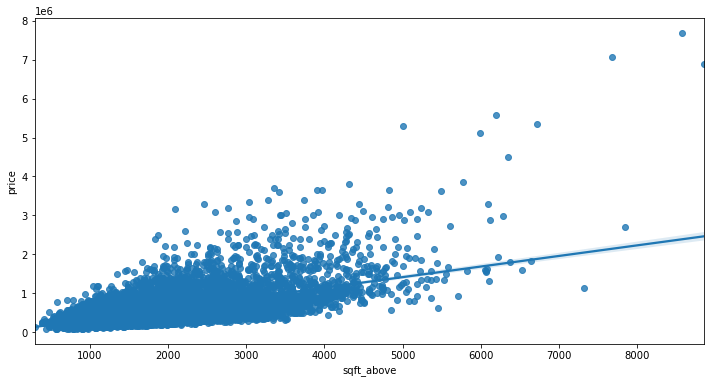

In [32]:
# sqft_above
concat_data = pd.concat([data['price'], data['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.regplot(x='sqft_above', y='price', data=concat_data)

sqft_above와 가격은 약간의 상관 관계가 있는 것으로 보인다. 가격이 6 이상일 때 이상치가 있는 것처럼 보인다.  

In [33]:
data.loc[data['sqft_above'] > 8000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


가격이 6000000 이상일 경우는 지역의 영향 때문에 가격이 높이 매매된 것으로 보이므로 제거하지 않는다. 

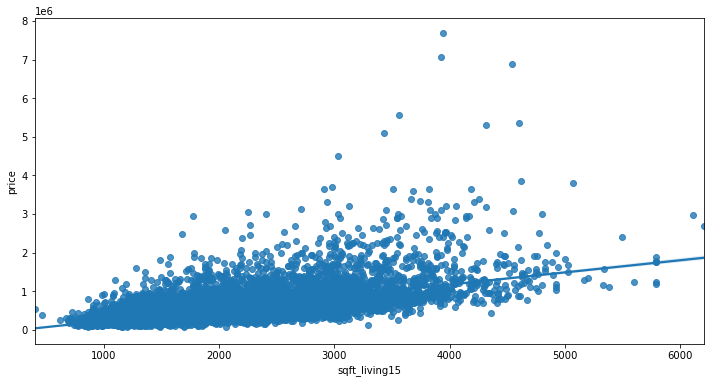

In [34]:
# sqft_living15 
concat_data = pd.concat([data['price'], data['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.regplot(x='sqft_living15', y='price', data=concat_data)

In [35]:
data.loc[data['price'] > 6000000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
5108,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


가격이 6000000 이상인 점은 sqft_above에서 본 것과 같은 데이터이므로 제거하지 않는다. 

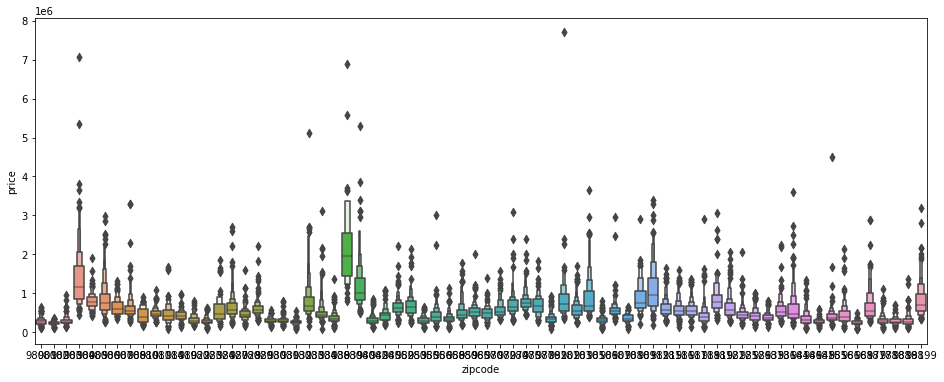

In [36]:
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxenplot(x='zipcode', y='price', data=data)

zip code에 따라 집의 가격이 변화하는 것을 볼 수 있다. 이상치처럼 보이는 것들은 위에서 살펴본 다른 변수 때문에 가격이 올라간 것으로 보아 제거하지 않는다.

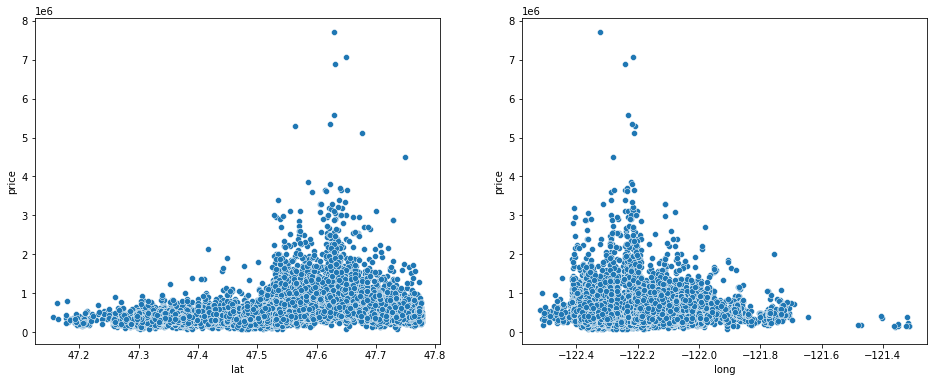

In [37]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))
fig = sns.scatterplot(x='lat', y='price', data=data, ax=ax[0])
fig = sns.scatterplot(x='long', y='price', data=data, ax=ax[1])

위도와 경도를 확인했을 때, 특정 위경도에 고가인 집들이 모여있는 것을 볼 수 있다. 그러나 가격이 현저히 차이나는 부분이 보여서 확인해 보았다.

In [38]:
data.loc[data['price'] > 5000000] 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
842,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
947,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1045,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
2775,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


집값이 비싼 데이터들은 grade가 높다는 것을 발견할 수 있다. 따라서 제거하지 않는다.

### 학습 데이터에서 라벨 제거하기
price 컬럼은 목적 변수로, 모델을 돌려 예측한 값과 비교해야 하므로 따로 y라는 변수에 저장한 후 해당 컬럼은 지워준다.

In [39]:
# price컬럼 제거
y = data['price']
del data['price']

print(data.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [40]:
y.describe()

count    1.503400e+04
mean     5.405670e+05
std      3.712661e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

표준편차가 3이므로 가격의 분포가 넓게 되어 있다는 것을 알 수 있다. 왜도와 점도를 그래프와 수치로 알아본다.

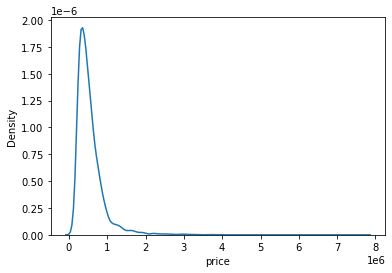

In [41]:
# 원래 price 분포
sns.kdeplot(y)
plt.show()

In [42]:
#skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 4.293603
Kurtosis: 40.251450


가격이 왼쪽으로 치우쳤고, skewness도 크므로 오른쪽으로 꼬리가 길다는 것을 알 수 있다. Kurtosis가 크므로 그래프가 뾰족하게 나타났다. 따라서 가격은 정규분포를 따르지 않는다. 회귀 분석을 하기 위해서는 정규 분포를 따르는 변수를 사용해야 하므로 로그를 씌워 정규 분포를 만들어준다. 

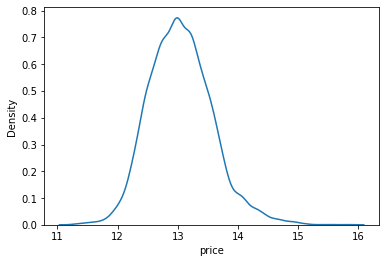

In [43]:
# 로그 변환 후 price 분포
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

위에서 저장해두었던 train_len을 인덱스로 활용해서 [:train_len]까지는 학습 데이터 x에 저장하고, [train_len:]부터는 테스트 데이터 sub 변수에 저장한다.

### 학습 데이터와 테스트 데이터 합치기
전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합친다. 그러나 모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 train_len에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용한다.

In [44]:
# training data의 개수
train_len = len(data)

# 학습, 평가 데이터 합치기
data = pd.concat((data, sub), axis=0)

print(train_len)

15034


### 각 변수들의 분포 확인
전체 데이터들의 분포를 확인하여 너무 치우친 분포를 가지는 컬럼은 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는다. 우선 필요없는 정보인 id와 date는 제거한다. 

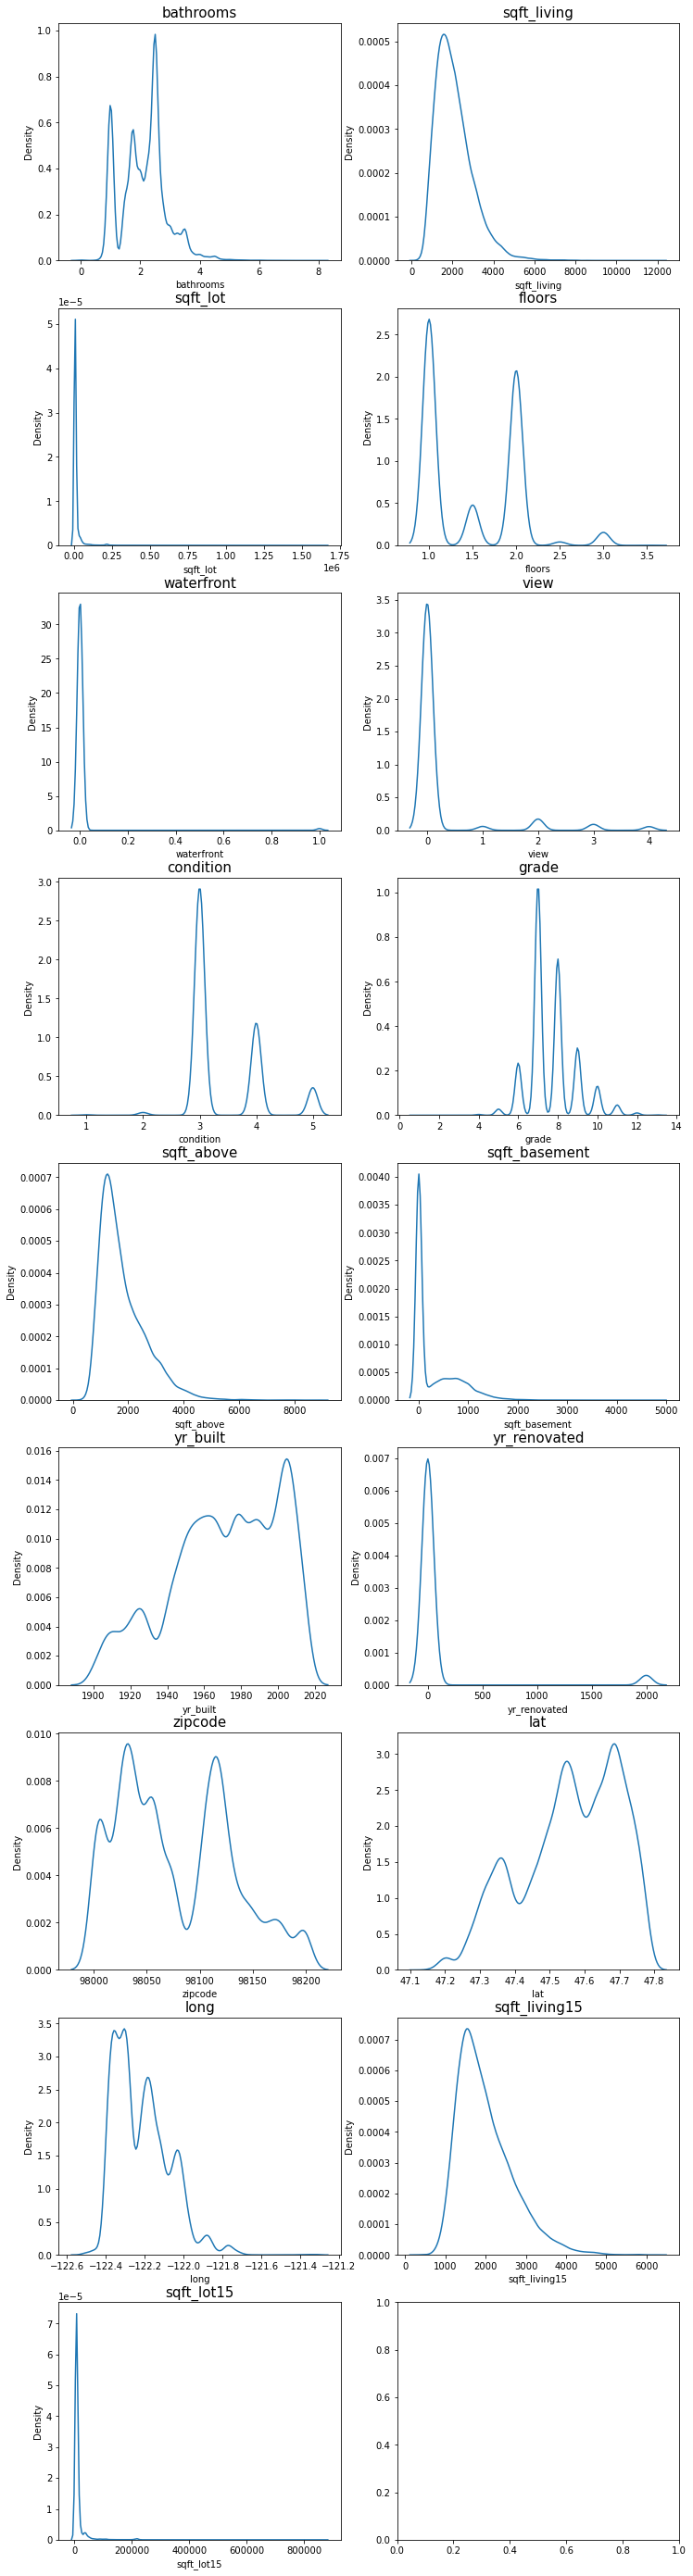

In [45]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포 확인
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15변수가 한쪽으로 치우친 경향을 보인다. 
회귀 분석을 하기 위해서는 정규 분포를 따르는 변수를 사용해야 하므로 로그 변환(log-scaling)을 통해 데이터 분포를 정규 분포에 가깝게 만든다. 

In [46]:
# 분포가 치우친 컬럼을 로그 변환 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)  # 자연로그 log(1 + x)을 반환해 주는 함수

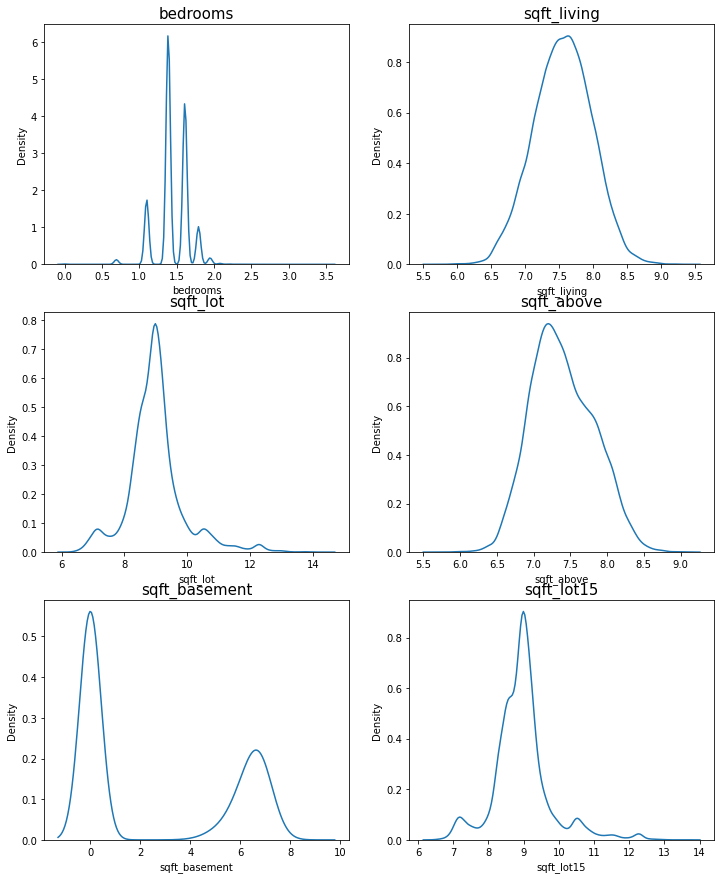

In [47]:
# 확인
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 6:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

위에서 저장해두었던 train_len을 인덱스로 활용해서 [:train_len]까지는 학습 데이터 x에 저장하고, [train_len:]부터는 테스트 데이터 sub 변수에 저장한다.

In [48]:
# 데이터 변환 후, 학습 데이터와 평가 데이터로 나누기
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15034, 18)
(6468, 18)


## 모델 튜닝

### 반복되는 작업을 함수로 만들기
앞으로 필요하게 될 RMSE를 구하는 함수, 모델별 RMSE 점수 구하는 함수, 그리드 탐색하는 함수를 미리 만들어 놓는다.
#### RMSE를 구하는 함수

In [49]:
# 라이브러리 호출
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [50]:
# 평가 척도인 RMSE를 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

####  모델별 RMSE 점수 구하는 함수

In [51]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [52]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅 -> 동일한 결과 나옴

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]  # 모델 인스턴스 리스트에 넣기

In [53]:
def get_scores(models, train, y):
       df = {}
     
       for model in models:
              model_name = model.__class__.__name__   # 모델 이름 획득
              # train, test 데이터셋 분리
              X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.3)
              model.fit(X_train, y_train)      # 모델 학습
              y_pred = model.predict(X_test)   # 예측
              
              df[model_name] = rmse(y_test, y_pred)    # 예측 결과의 rmse값 저장
              # data frame에 저장
              score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
              
              return score_df
            
get_scores(models, x, y)

,RMSE
GradientBoostingRegressor,132956.836573


#### 램덤 탐색 구하는 함수
그리드 탐색으로는 결과가 좋지 않아 그리드 탐색보다 결과가 좋다는 랜텀 탐색으로 방법을 바꾸었다. 결과적으로 그리드 탐색보다 좋은 결과가 나왔다.

In [54]:
from sklearn.model_selection import RandomizedSearchCV
def RandomSearch(model, train, y, param_grid):
       # RandomSearchCV를 이용해 모델 초기화
       random_search = RandomizedSearchCV(estimator=model, param_distributions=param_list, \
                                  scoring='neg_mean_squared_error', n_iter=10, cv=5)
     
       random_search.fit(train, y)                # 모델 학습 
       # 결과값 저장
       params = random_search.cv_results_['params']              # 파라미터 조합 
       score = random_search.cv_results_['mean_test_score']      # 테스트 점수
       
      # 데이터 프레임 만들기
       results= pd.DataFrame(params)                             
       results['scores'] = score                                             # 스코어 컬럼 추가
       results['RMSLE'] = np.sqrt(-1 * results['scores'])    # RMSE 만들어 컬럼 추가
       results = results.sort_values('RMSLE')                 # 위의 표를 `RMSLE`가 낮은 순서대로 정렬
      
       return results

### 랜덤 탐색하기

#### lgbm

In [64]:
param_list = {
     "max_depth": [5, 6]
      , "n_estimators": [800, 900, 1000, 1100, 1200]
      , "max_features": [4, 8, 16, 32]
      , 'num_leaves': [25, 31, 37, 41]
     }
    
model = LGBMRegressor(random_state=random_state)
RandomSearch(model, x, y, param_list)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] U

,num_leaves,n_estimators,max_features,max_depth,scores,RMSLE
6,25,1100,4,6,-0.027801,0.166736
5,41,900,16,5,-0.027858,0.166908
7,37,800,8,6,-0.027905,0.167048
0,41,800,4,6,-0.027971,0.167244
4,41,800,32,6,-0.027971,0.167244
8,31,1000,32,5,-0.028023,0.167402
3,31,1100,4,5,-0.028131,0.167723
2,25,1200,16,5,-0.028159,0.167805
1,41,1000,16,6,-0.028253,0.168085
9,41,1100,16,6,-0.028335,0.168331


In [ ]:
# 사용했던 파라미터 1
# param_list = {
#     'learning_rate': [0.08],
#     'n_estimators': list(range(400, 1000, 400)),
#     'max_depth': [50, 100, 22, 24],
#     'max_features': [3, 5, 7, 9],
#     'min_samples_split': [3, 5, 7, 9], 
#     'num_iterations': [2000],
#     'boosting': ['gbdt'],
#     'objective': ['regression'], 
#     'tree_method':['gpu_hist'],
#     'predictor':['gpu_predictor'] 
# }
# param_grid = {
#     'objective':['regression'],
#     'learning_rate' : [0.1],
#     'n_estimators': [400, 800, 1200],
#     'max_depth': [18, 20, 22],
#}
#param_grid = {
#     'learning_rate': [0.1],
#     'subsample': [0.9],
#     'learning_rate' : [0.05],
#     'n_estimators': [400, 800, 1200],
#     'max_depth': [18, 20, 22],
#}
# param_list = {
#     'learning_rate': [0.1],
#     'n_estimators': list(range(400, 1000, 400)),
#     'max_depth': [18, 20, 22, 24],
#     'max_features': [3, 5, 7, 9],
#     'min_samples_split': [3, 5, 7, 9],
#}

### 모델 준비

In [65]:
random_state=2020

In [66]:
LGBM_model = LGBMRegressor(
     max_depth=6, 
     n_estimators=1100, 
     max_features=4, 
     num_leaves=25,
     random_state=random_state)


### 모델 학습하고 결과 얻기

In [67]:
def get_prediction(model, train, y, test):
       model.fit(train, y)                # 모델 학습
       prediction = model.predict(test)          # 예측결과 
       prediction = np.expm1(prediction)  # 원래 스케일로 되돌리기 - 예측 결과에 np.expm1()을 씌우기
       return prediction

In [68]:
LGB_prediction = get_prediction(LGBM_model, x, y, sub)
LGB_prediction

array([ 525947.57676628,  503742.02514849, 1356295.12435449, ...,
        488590.55825079,  344299.10253888,  445085.44894197])

## 제출 준비

In [69]:
# sample_submission.csv 파일 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [70]:
# 위의 데이터프레임에 모델의 값 덮어씌우기
submission['price'] = LGB_prediction
submission.head()

,id,price
0,15035,5.259476e+05
1,15036,5.037420e+05
2,15037,1.356295e+06
3,15038,2.733509e+05
4,15039,3.235784e+05


In [71]:
# csv 파일로 저장 - 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것입니다!
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj44/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


## 결과
여러 가지를 시도하여 결과를 얻어내었다. 

1. Baseline 커널에서 활용한 블렌딩 방법 사용        
결과: 115281.56048     120945.95345

2. 그리드 탐색으로 하이퍼파라미터 튜닝하고 블렌딩 방법 사용      
1) 노드에 있는 기본 하이퍼파라미터 사용      
결과: 126005.49033       129583.95140        
2) 바꾼 하이퍼파라미터 사용 1        
결과: 119991.54819   123044.9855

3. 그리드 탐색으로 하이퍼파라미터 튜닝하고 LGBM 모델 사용        
결과: 122994.78888 124236.71233

4. 랜덤 탐색으로 하이퍼파라미터 튜닝하고 LGBM 모델 사용         
결과: 113345.58263     113528.52643

5. 랜덤 탐색으로 하이퍼파라미터 튜닝하고 블렌딩 방법 사용       
결과: 116482.37920    119276.83607

6. 랜덤 탐색으로 하이퍼파라미터 튜닝하고 LGBM 모델 사용         
결과: 113322.02416    109151.38942

7. 랜덤 탐색으로 하이퍼파라미터 튜닝하고 LGBM 모델 사용         
결과: 112980.60010      109056.63110

이후 7번의 방법으로 하이퍼파라미터를 계속 튜닝하였으니 private score가 잘 떨어지지 않았다. 

![](https://images.velog.io/images/guide333/post/e94fdd18-3ba9-474e-a10f-e477e6d5b48c/Screenshot%20from%202021-02-18%2019-35-57.png)

## 루브릭
|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?.|데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.|Y     |
|2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?|제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.|Y?     |
|3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?|다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.| N   |

## 후기
### 이번 프로젝트에서 어려웠던 점
- 집값에 큰 영향을 미치는 지역을 어떻게든 사용해보려고 노력하였으나 결국은 하지 못하였다. 이에 대한 비교적 쉬운 커널을 찾았으니 시간이 날 때 공부해볼 예정이다.
- 이상치 제거나 전처리 순서에 따라 결과가 많이 달라졌고, 이부분을 해결하는 것이 어려웠다. 
- 하이퍼파라미터를 튜닝하고 모델을 설계하는 부분이 어려웠다. 다양한 시도를 하다가 결과가 너무 안 좋게 나올 때가 있었다. 알고보니 모델 설계가 잘못 된 것이었다. 하이퍼파라미터도 어떻게 설정하느냐에 따라 결과가 천차만별이어서 여러 가지 시도를 하느라 시간이 많이 걸렸다.  
- 그리드/랜덤 탐색에 많은 시간이 걸렸고, 때로는 커널이 죽는 경우도 있었다. 

### 프로젝트를 진행하면서 알게된 점
캐글 대회를 어떻게 진행해야 하는지 조금은 알 것 같다.  

### 프로젝트를 진행하면서 아직 모호한 점
- 데이터마다 EDA와 전처리를 다르게 해야하는데 아직 이 부분을 어떻게 해야 효과적으로 할 수 있는지 잘 모르겠다. 특히 이번 프로젝트에서는 지역이 집값에 영향을 크게 미치는 것을 볼 수 있었지만 이 부분을 잘 살리지 못해서 아쉽다. 시도하려고 하였지만 다른 사람들의 커널을 보고도 이해하지 못해 시도하지 못했다. 
- 이상치 제거 부분에서 가격이 특별한 높거나 낮은 이유를 알 수 없어서 데이터를 제거하였더니 결과가 안 좋아지는 경우가 있었다. 지역에 대한 특성을 집어넣었더라면 쉽게 해결될 수 있는 부분이 아니었나 싶다.
- 좋은 하이퍼파라미터를 찾고 적당한 모델을 사용하는 법을 아직 잘 모르겠다. 다른 사람들의 커널을 보았지만 이해할 수 없었다. 

### 자기 다짐
캐글에 대한 감을 잡지 못해서 1차 해커톤을 제대로 하지 못해서 아쉬움이 많이 남았었다. 다른 조들이 한 것을 보고서야 어떻게 해야 하는지 조금 깨달았다. 그래서 이번 프로젝트에 최선을 다해 캐글에 대해 공부해 보고 싶었다. 하지만 생각보다 쉽지는 않았다. 전처리나 모델 설계를 잘못해서 말도 안 되는 결과가 나오기도 했고 제대로 했다고 생각했는데도 베이스라인보다 나쁜 결과를 얻기도 했다. 그나마 랜덤 탐색으로 처음으로 점수가 떨어져서 안도했다. 그러나 아무리 하이퍼파라미터를 튜닝해도 루브릭의 기준 점수보다 낮은 점수를 얻지 못했다. 노드에서 제안한 방법도 사용해 보고, 다양한 하이퍼파라미터를 추가해도 점수가 점점 올라가기만 한다.  
결국 이번에는 포기하지만 앞으로 시간이 날 때마다 혼자서라도 캐글을 공부해보고 싶다. 좋은 점수를 얻은 사람들은 노드에서 배우지 않은 모델을 사용하거나 지역 특성과 같이 새로운 특성을 만들어서 변수에 집어 넣는 것을 발견했다. 아직 내 수준으로는 그 코드들을 이해할 수 없지만 더 공부해서 이해할 수 있었으면 좋겠다. 